# Inaugural Project

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc0_)
- [Q1, Relative time spent working at home](#toc1_)        
- [Q2, Relative wage, discretely](#toc2_)
- [Q3, Relative wage, continously](#toc3_)
- [Q4, Fitting the model to parameter estimates](#toc4_)
- [Q5, Fitting model, equal home productivity](#toc5_)           
- [Conclusion](#toc6_)    

## <a id='toc0_'></a>[Introduction](#toc0_)

In this project we investigate the time use of couples when both are working at home and in the labour market. We will be looking at the relative hours of work spent at home. 

In [15]:
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm # for colormaps

# Autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import inauguralproject
from inauguralproject import HouseholdSpecializationModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <a id='toc1_'></a>[Q1, Relative time spent working at home](#toc0_)

In question 1, we examine the male relative to female working hours at home $\frac{H_F}{H_M}$, from here on out: relative home hours. 


We solve for the optimal number of hours spent at work - illustration of $\frac{H_F}{H_M}$ for $\alpha \in \{ 0.25, 0.50, 0.75\}$ and $\sigma \in \{ 0.5, 1.0, 1.5\}$

**Calculating the optimal relative hours**

 Relativ hours worked given (alpha,sigma)
           0.5       1.0       1.5
0.25  0.545455  0.307692  0.214286
0.50  1.000000  1.000000  1.000000
0.75  1.833333  3.250000  4.666667
Plotting table


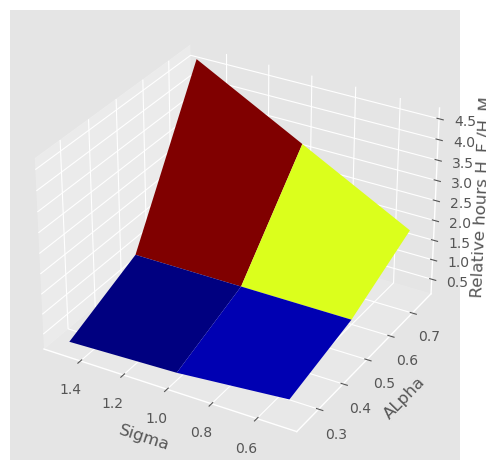

In [25]:
# 1. Create an instance of the model class
model_1 = HouseholdSpecializationModelClass()

# 2. Set parameter lists
list_alpha = [0.25, 0.5, 0.75]
list_sigma = [ 0.5, 1.0, 1.5]

# 3. Generate table
table = model_1.q1_gen_table(list_alpha,list_sigma)

# 4. Print table
print(f' Relativ hours worked given (alpha,sigma)')
print(table )

# 5. 3D plot of table 
print(f'Plotting table')
model_1.q1_plot_table(table)

The effects of varrying $\alpha$ & $\sigma$ can be examined in the illustration above. It shows that an increase in $\alpha$ or $\sigma$ increase the hours worked at home by the female relative to the male. 

This is in line with expectations from the model as the parameters increase the productivity/importance of the female working at home.

## <a id='toc2_'></a>[Q2, Relative wage, discretely](#toc0_)

**Plotting the relative wage, discretely**

In this question, we examine the relation between the relative hours worked at home and the relative wage (log) for the discrete model.



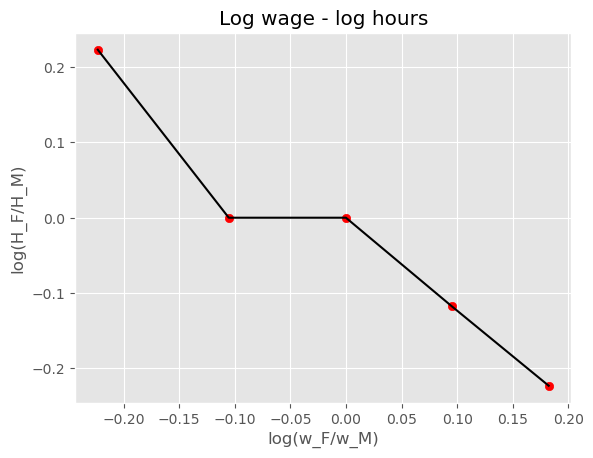

In [26]:
# 1. Create an instance of the model class
model_2 = HouseholdSpecializationModelClass()

# 2. Set parameter lists
wF_vec = np.linspace(0.8,1.2,5)

# 3. Solving for the optimal hours worked given the relative wage 
log_rel_wage, log_rel_hours = model_2.solve_wage_work(  discrete=True)

# 4. Plotting the results
model_2.q2_plot(log_rel_wage, log_rel_hours);

**Intuition**

The illustration shows that as the female wage rises, the optimal number of hours at home fall. The kink in the figure is due to the model being discrete. 

## <a id='toc3_'></a>[Q3, Relative wage, continously](#toc0_)

**Plotting relative wage continuously**

In this question we examine the relation between the relative hours worked at home and the relative wage (log) in a discrete model, where the choice of hours spent working is continuous.



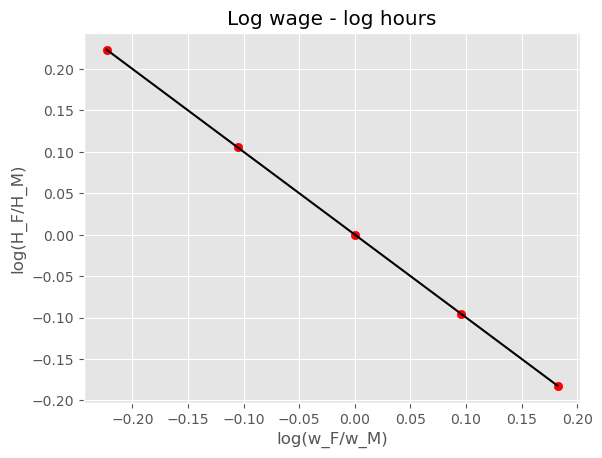

In [27]:
# 1. Create an instance of the model class
model_3 = HouseholdSpecializationModelClass()

# 2. Set parameter lists
wF_vec = np.linspace(0.8,1.2,5)

# 3. Solving for optimal hours worked given relative wages
log_rel_wage, log_rel_hours = model_3.solve_wage_work( discrete=False)

# 4. Plotting the results
model_3.q2_plot(log_rel_wage, log_rel_hours);

The instuition in the figure follows that of question 3. If the female wage increase, she will work more, and therefore have less time to work at home. In this case there is no kink.

## <a id='toc4_'></a>[Q4, Fitting the model to parameter estimates](#toc0_)

For the model to fit the regression estimates in Siminski and Yetsenga (2022), *Specialization, Comparative Advantage, and the Sexual Devision of Labor*, we have $\alpha$ = 0.98 & $\sigma$ = 0.10. That is, females are far more productive working at home relative to men.



 This gives the parameters: 
   alpha = 0.98 
   sigma = 0.10
 With the squared error 0.00


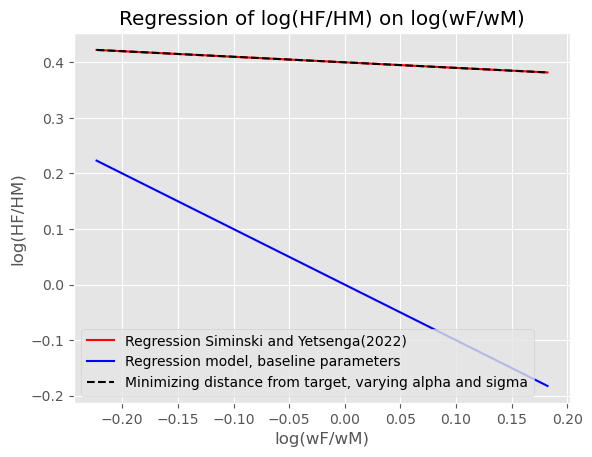

In [33]:
# 1. Create an instance of the model class
model_4 = HouseholdSpecializationModelClass()

# 2. Regressions parameters from the paper
par = model_4.par
beta0_target = par.beta0_target
beta1_target = par.beta1_target

# 3.  Regression with origional parameters (equally productive at home)
beta0_base, beta1_base = model_4.run_regression() 

# 4:  
#   i. Regression for minimizing the distance between the regression parameters and the target parameters
alpha_hat, sigma_hat, err = model_4.q4_min_error()

#   ii. Regression for new parameters
par.alpha = alpha_hat
par.sigma = sigma_hat
beta0_hat, beta1_hat = model_4.run_regression() 

# 5. Plotting the results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(log_rel_wage, beta0_target + beta1_target*log_rel_wage, label='Regression Siminski and Yetsenga(2022)', color='red')
ax.plot(log_rel_wage, beta0_base + beta1_base*log_rel_wage, label='Regression model, baseline parameters', color='blue')
ax.plot(log_rel_wage, beta0_hat + beta1_hat*log_rel_wage, label='Minimizing distance from target, varying alpha and sigma', color='black', linestyle='dashed')

ax.title.set_text('Regression of log(HF/HM) on log(wF/wM)')
ax.legend()
ax.set_xlabel('log(wF/wM)');
ax.set_ylabel('log(HF/HM)');

## <a id='toc5_'></a>[Q5, Fitting model, equal home productivity](#toc0_)

We implement an extension to the model such that we can match the empirical findings, regardless of men and women being equally productive in the home ($\alpha$ fixed at 0.5). Our extension involves adding an extra disutility term, $\theta$, for each other a man is working at home.

$$
\underset{L_M, H_M, L_F, H_F}  {max} \quad \frac{Q^{1-\rho}}{1-\rho} - \nu \cdot \left( \frac{T_M^{1+ \frac{1}{\epsilon}}}{1 + \frac{1}{\epsilon}} + \frac{T_F^{1+ \frac{1}{\epsilon}}}{1 + \frac{1}{\epsilon}} + \theta \cdot H_M \right), \rho > 1, \nu > 0, \epsilon > 0
$$

$\hat{\theta}$ = 1.93 and $\hat{\sigma}$ = 0.01 minimize the squared errors, and the fit is somewhat good with $(\beta_0-\hat{\beta_0})^2+(\beta_1-\hat{\beta_1})^2=0.01$, cf. the graph below.



 This gives the parameters: 
   theta = 1.93 
   sigma = 0.01
 With the squared error 0.01


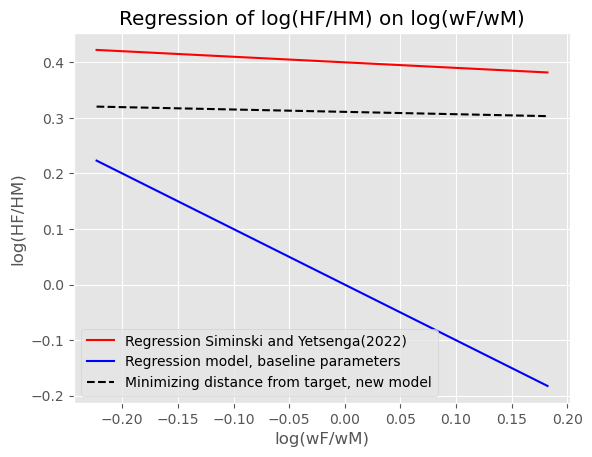

In [32]:
# 1. Create an instance of the model class
model_5 = HouseholdSpecializationModelClass()

# 2:  
#   i. Regression for minimizing the distance between the regression parameters and the target parameters
theta_hat, sigma_hat, err = model_5.q5_min_error()

#   ii. Regression for new parameters
par.theta = theta_hat
par.sigma = sigma_hat
beta0_hat, beta1_hat = model_5.run_regression() 

# 4. Plotting the results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(log_rel_wage, beta0_target + beta1_target*log_rel_wage, label='Regression Siminski and Yetsenga(2022)', color='red')
ax.plot(log_rel_wage, beta0_base + beta1_base*log_rel_wage, label='Regression model, baseline parameters', color='blue')
ax.plot(log_rel_wage, beta0_hat + beta1_hat*log_rel_wage, label='Minimizing distance from target, new model', color='black', linestyle='dashed')

ax.title.set_text('Regression of log(HF/HM) on log(wF/wM)')
ax.legend()
ax.set_xlabel('log(wF/wM)');
ax.set_ylabel('log(HF/HM)');

## <a id='toc6_'></a>[Conclusion](#toc0_)

First of all, we can explain a logical behavior in the model itself when the relative productivity of working at home changes.

However, we cannot explain the estimates provided in Siminski and Yetsenga (2022) with this simple model and each sex being equally productive when working at home.
Trying to fit the model in our simple one, we need women to be a lot more productive working at home, $\alpha$ $\approx$ 1.

When adding an extra disutility term for men when working at home, we can fit the extended simple model with the estimates in the paper (with a squared error 0.01). However, this means that men dislike working at home more than women.